2R2C Thermal Model Development for Freezer System
==================================================

This notebook develops and validates a 2R2C thermal resistance-capacitance model
for a cold storage freezer facility using measured temperature and operation data.

Model Structure:
- R1: Thermal resistance from ambient to freezer air
- C1: Thermal capacitance of freezer air  
- R2: Thermal resistance from freezer air to ice cream product
- C2: Thermal capacitance of stored ice cream product

Author: Rongxin Yin and Claude
Date: August 2025

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize, signal
from scipy.integrate import odeint
import gurobipy as gp
from gurobipy import GRB
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== 2R2C Freezer Thermal Model Development ===\n")

ModuleNotFoundError: No module named 'gurobipy'

In [14]:
# SECTION 1: DATA LOADING AND PREPROCESSING
print("1. LOADING AND MERGING DATASETS")
print("=" * 50)

# Load datasets
try:
    df_power = pd.read_csv('freezer_power_resampled.csv')
    df_temp = pd.read_csv('freezer_temperature_resampled.csv')
    print("✓ Successfully loaded both datasets")
except FileNotFoundError as e:
    print(f"❌ Error loading files: {e}")
    print("Please ensure both CSV files are in the working directory")

# Display basic info about datasets
print(f"\nPower dataset shape: {df_power.shape}")
print(f"Temperature dataset shape: {df_temp.shape}")

print("\nPower dataset columns:", df_power.columns.tolist())
print("Temperature dataset columns:", df_temp.columns.tolist())

# Convert datetime columns
df_power['DateTime'] = pd.to_datetime(df_power['DateTime'])
df_temp['DateTime'] = pd.to_datetime(df_temp['DateTime'])

# Check data ranges
print(f"\nPower data time range: {df_power['DateTime'].min()} to {df_power['DateTime'].max()}")
print(f"Temperature data time range: {df_temp['DateTime'].min()} to {df_temp['DateTime'].max()}")

# Merge datasets on DateTime
df_merged = pd.merge(df_temp, df_power, on='DateTime', how='inner')
print(f"\nMerged dataset shape: {df_merged.shape}")
print("✓ Successfully merged datasets")

# Sort by datetime and reset index
df_merged = df_merged.sort_values('DateTime').reset_index(drop=True)

# Display sample of merged data
print("\nSample of merged data:")
print(df_merged.head())

# Check for missing values
print(f"\nMissing values:")
print(df_merged.isnull().sum())

1. LOADING AND MERGING DATASETS
❌ Error loading files: [Errno 2] No such file or directory: 'freezer_power_resampled.csv'
Please ensure both CSV files are in the working directory

Power dataset shape: (16595, 3)
Temperature dataset shape: (4896, 2)

Power dataset columns: ['DateTime', 'is_defrost', 'compressor_on']
Temperature dataset columns: ['DateTime', 'Temperature_C']

Power data time range: 2025-07-01 00:00:00 to 2025-08-27 14:50:00
Temperature data time range: 2025-07-01 00:00:00 to 2025-07-17 23:55:00

Merged dataset shape: (4896, 4)
✓ Successfully merged datasets

Sample of merged data:
             DateTime  Temperature_C  is_defrost  compressor_on
0 2025-07-01 00:00:00     -33.799701         0.0            1.0
1 2025-07-01 00:05:00     -33.876922         0.0            1.0
2 2025-07-01 00:10:00     -33.979883         0.0            1.0
3 2025-07-01 00:15:00     -34.074264         0.0            1.0
4 2025-07-01 00:20:00     -34.168645         0.0            1.0

Missing val

# SECTION 2: SYSTEM SPECIFICATIONS AND UNIT CONVERSIONs

In [15]:
print("\n\n2. SYSTEM SPECIFICATIONS AND UNIT CONVERSIONS")
print("=" * 60)

# Given specifications
specs = {
    'floor_area_ft2': 840,
    'floor_height_ft': 25,
    'freezer_setpoint_F': -30,
    'ice_cream_area_fraction': 1/3,
    'ice_cream_height_ft': 4,
    'ice_cream_entry_temp_F': -5,
    'ambient_temp_C': 21.1,
    'cooling_capacity_MBH_min': 68.3,  # Million BTU/hr
    'cooling_capacity_MBH_max': 95.2,
    'defrost_power_kW_min': 10,
    'defrost_power_kW_max': 16
}

# Ice cream properties
ice_cream_props = {
    'conductivity_W_mK': 4.48462013857049E-02,
    'density_kg_m3': 1121.2917044623,
    'specific_heat_J_kgK': 2719.6000205792
}

# Unit conversion functions
def fahrenheit_to_celsius(temp_f):
    return (temp_f - 32) * 5/9

def celsius_to_fahrenheit(temp_c):
    return temp_c * 9/5 + 32

def ft_to_m(length_ft):
    return length_ft * 0.3048

def ft2_to_m2(area_ft2):
    return area_ft2 * 0.092903

def ft3_to_m3(volume_ft3):
    return volume_ft3 * 0.0283168

def MBH_to_W(mbh):
    return mbh * 1000000 * 1055.06 / 3600  # Million BTU/hr to Watts

# Convert specifications to SI units
specs_SI = {}
specs_SI['floor_area_m2'] = ft2_to_m2(specs['floor_area_ft2'])
specs_SI['floor_height_m'] = ft_to_m(specs['floor_height_ft'])
specs_SI['freezer_volume_m3'] = specs_SI['floor_area_m2'] * specs_SI['floor_height_m']
specs_SI['freezer_setpoint_C'] = fahrenheit_to_celsius(specs['freezer_setpoint_F'])
specs_SI['ice_cream_volume_m3'] = (specs_SI['floor_area_m2'] * specs['ice_cream_area_fraction'] * 
                                   ft_to_m(specs['ice_cream_height_ft']))
specs_SI['ice_cream_entry_temp_C'] = fahrenheit_to_celsius(specs['ice_cream_entry_temp_F'])
specs_SI['ambient_temp_C'] = specs['ambient_temp_C']
specs_SI['cooling_capacity_W_min'] = MBH_to_W(specs['cooling_capacity_MBH_min'])
specs_SI['cooling_capacity_W_max'] = MBH_to_W(specs['cooling_capacity_MBH_max'])
specs_SI['defrost_power_W_min'] = specs['defrost_power_kW_min'] * 1000
specs_SI['defrost_power_W_max'] = specs['defrost_power_kW_max'] * 1000

print("System Specifications (SI Units):")
for key, value in specs_SI.items():
    if 'temp' in key:
        print(f"  {key}: {value:.2f} °C")
    elif 'power' in key or 'capacity' in key:
        print(f"  {key}: {value:.0f} W")
    elif 'volume' in key:
        print(f"  {key}: {value:.2f} m³")
    elif 'area' in key:
        print(f"  {key}: {value:.2f} m²")
    else:
        print(f"  {key}: {value:.3f}")




2. SYSTEM SPECIFICATIONS AND UNIT CONVERSIONS
System Specifications (SI Units):
  floor_area_m2: 78.04 m²
  floor_height_m: 7.620
  freezer_volume_m3: 594.65 m³
  freezer_setpoint_C: -34.444
  ice_cream_volume_m3: 31.71 m³
  ice_cream_entry_temp_C: -20.56 °C
  ambient_temp_C: 21.10 °C
  cooling_capacity_W_min: 20016833 W
  cooling_capacity_W_max: 27900476 W
  defrost_power_W_min: 10000 W
  defrost_power_W_max: 16000 W


# SECTION 3: DATA ANALYSIS AND VISUALIZATION



3. EXPLORATORY DATA ANALYSIS
Dataset Statistics:
                  DateTime  Temperature_C   is_defrost  compressor_on
count                 4896    4896.000000  4896.000000    4896.000000
mean   2025-07-09 11:57:30     -32.482381     0.133374       0.866626
min    2025-07-01 00:00:00     -37.008650     0.000000       0.000000
25%    2025-07-05 05:58:45     -35.627258     0.000000       1.000000
50%    2025-07-09 11:57:30     -34.511848     0.000000       1.000000
75%    2025-07-13 17:56:15     -31.277158     0.000000       1.000000
max    2025-07-17 23:55:00       0.726533     1.000000       1.000000
std                    NaN       5.093428     0.340013       0.340013


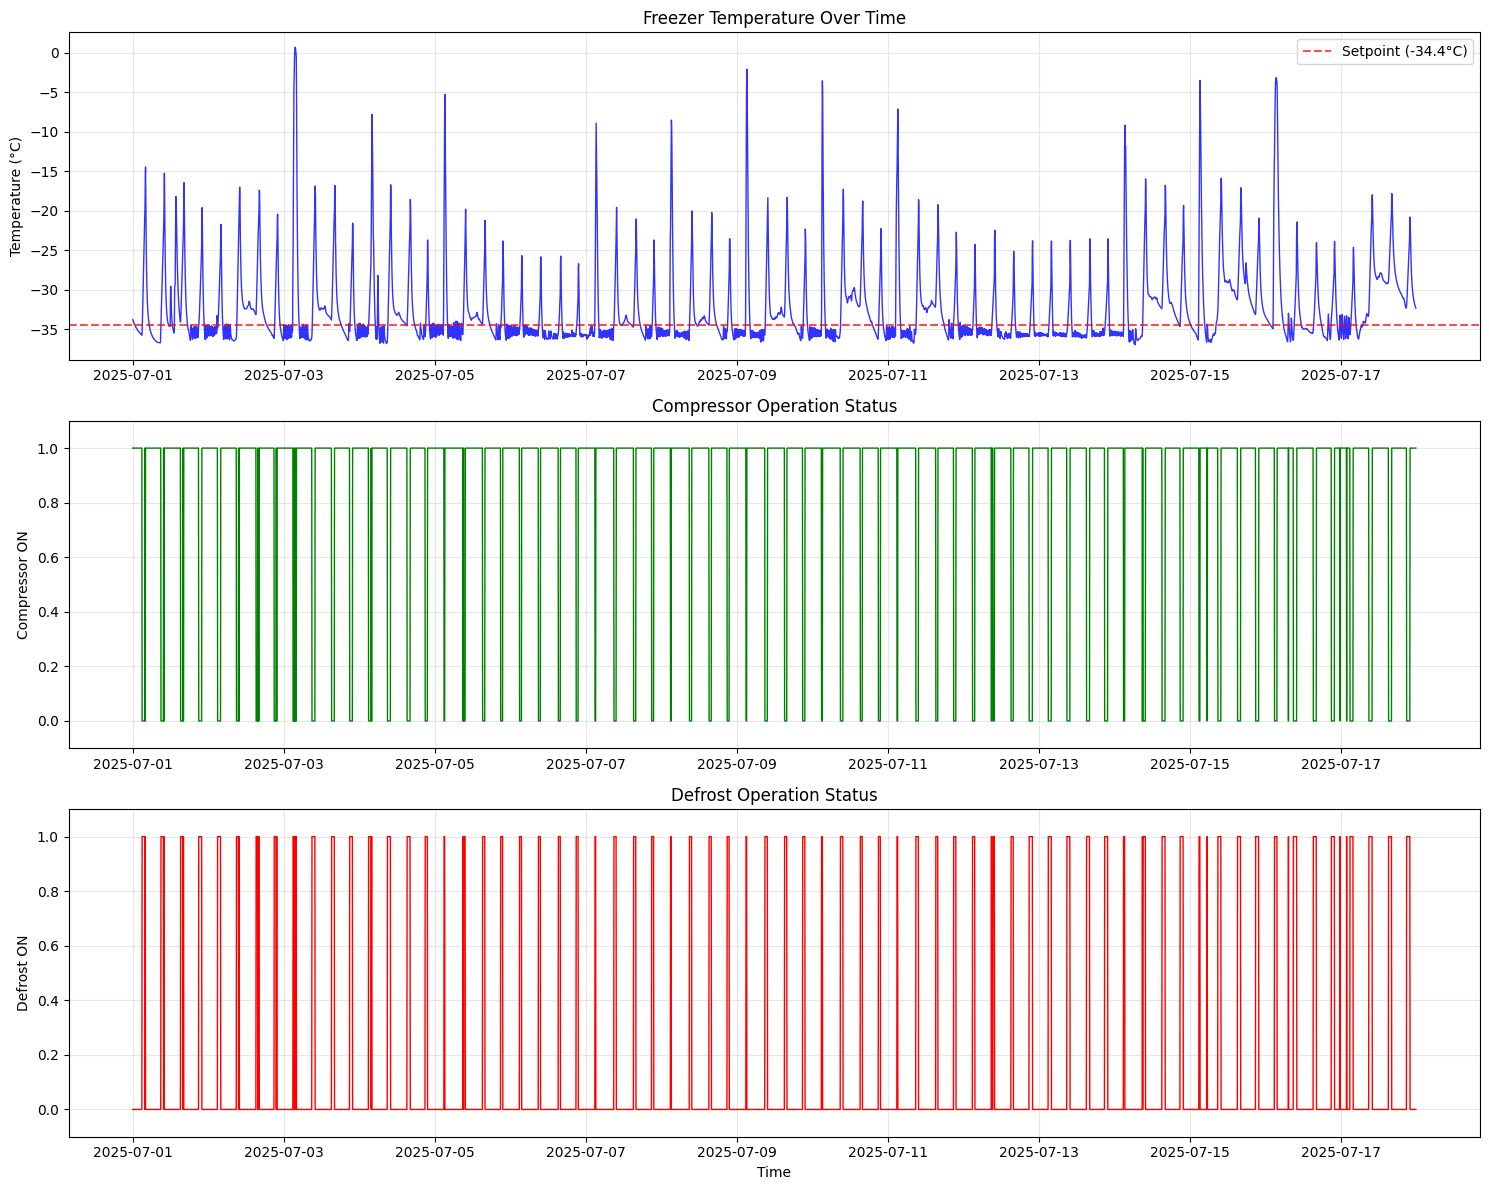

In [16]:
print("\n\n3. EXPLORATORY DATA ANALYSIS")
print("=" * 40)

# Basic statistics
print("Dataset Statistics:")
print(df_merged.describe())

# Create time-based plots
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Temperature vs time
axes[0].plot(df_merged['DateTime'], df_merged['Temperature_C'], 'b-', linewidth=1, alpha=0.8)
axes[0].axhline(y=specs_SI['freezer_setpoint_C'], color='r', linestyle='--', alpha=0.7, 
               label=f'Setpoint ({specs_SI["freezer_setpoint_C"]:.1f}°C)')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Freezer Temperature Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Compressor operation
axes[1].plot(df_merged['DateTime'], df_merged['compressor_on'], 'g-', linewidth=1)
axes[1].set_ylabel('Compressor ON')
axes[1].set_title('Compressor Operation Status')
axes[1].set_ylim(-0.1, 1.1)
axes[1].grid(True, alpha=0.3)

# Defrost operation
axes[2].plot(df_merged['DateTime'], df_merged['is_defrost'], 'r-', linewidth=1)
axes[2].set_ylabel('Defrost ON')
axes[2].set_xlabel('Time')
axes[2].set_title('Defrost Operation Status')
axes[2].set_ylim(-0.1, 1.1)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# SECTION 4: CORRELATION AND TIME LAG ANALYSIS



4. CORRELATION AND TIME LAG ANALYSIS
Temperature vs Compressor:
  Optimal lag: 5 time steps
  Max correlation: -0.621

Temperature vs Defrost:
  Optimal lag: 5 time steps
  Max correlation: 0.621


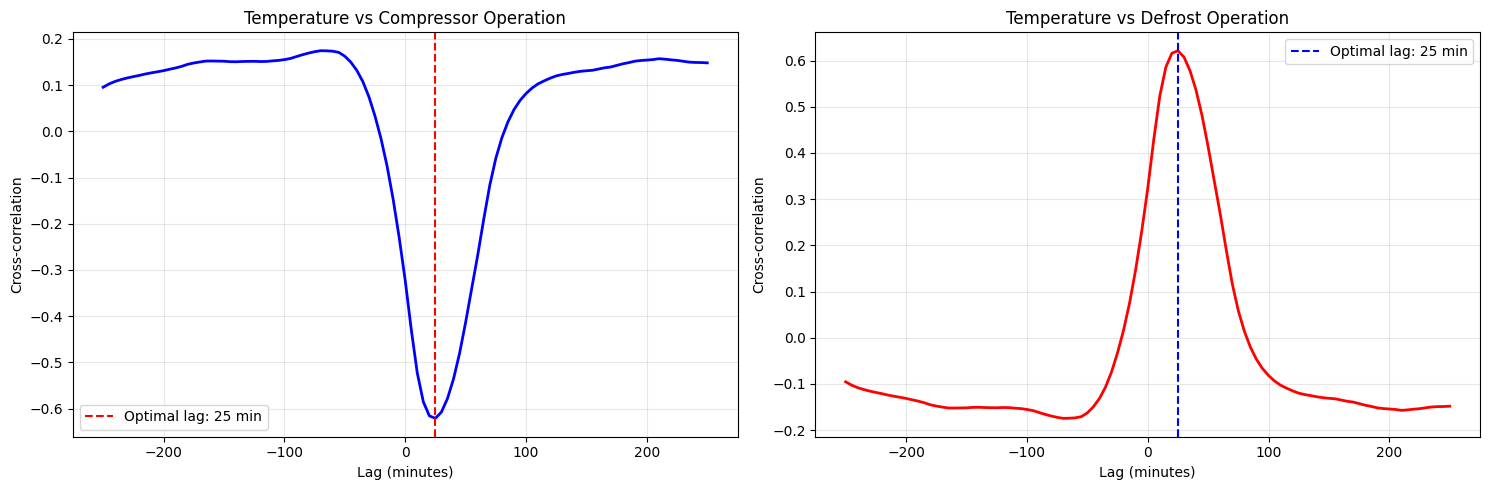

In [17]:
print("\n\n4. CORRELATION AND TIME LAG ANALYSIS")
print("=" * 45)

def calculate_cross_correlation(x, y, max_lag=50):
    """Calculate cross-correlation with time lags"""
    correlations = []
    lags = range(-max_lag, max_lag + 1)
    
    for lag in lags:
        if lag < 0:
            corr = np.corrcoef(x[:lag], y[-lag:])[0, 1]
        elif lag > 0:
            corr = np.corrcoef(x[lag:], y[:-lag])[0, 1]
        else:
            corr = np.corrcoef(x, y)[0, 1]
        correlations.append(corr)
    
    return np.array(lags), np.array(correlations)

# Calculate cross-correlations
lags_comp, corr_comp = calculate_cross_correlation(
    df_merged['Temperature_C'].values, 
    df_merged['compressor_on'].values
)

lags_defrost, corr_defrost = calculate_cross_correlation(
    df_merged['Temperature_C'].values, 
    df_merged['is_defrost'].values
)

# Find optimal lags
optimal_lag_comp = lags_comp[np.argmax(np.abs(corr_comp))]
optimal_corr_comp = corr_comp[np.argmax(np.abs(corr_comp))]

optimal_lag_defrost = lags_defrost[np.argmax(np.abs(corr_defrost))]
optimal_corr_defrost = corr_defrost[np.argmax(np.abs(corr_defrost))]

print(f"Temperature vs Compressor:")
print(f"  Optimal lag: {optimal_lag_comp} time steps")
print(f"  Max correlation: {optimal_corr_comp:.3f}")

print(f"\nTemperature vs Defrost:")
print(f"  Optimal lag: {optimal_lag_defrost} time steps") 
print(f"  Max correlation: {optimal_corr_defrost:.3f}")

# Plot cross-correlations
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(lags_comp * 5, corr_comp, 'b-', linewidth=2)  # *5 for 5-min intervals
axes[0].axvline(x=optimal_lag_comp * 5, color='r', linestyle='--', 
               label=f'Optimal lag: {optimal_lag_comp * 5} min')
axes[0].set_xlabel('Lag (minutes)')
axes[0].set_ylabel('Cross-correlation')
axes[0].set_title('Temperature vs Compressor Operation')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(lags_defrost * 5, corr_defrost, 'r-', linewidth=2)
axes[1].axvline(x=optimal_lag_defrost * 5, color='b', linestyle='--',
               label=f'Optimal lag: {optimal_lag_defrost * 5} min')
axes[1].set_xlabel('Lag (minutes)')
axes[1].set_ylabel('Cross-correlation')
axes[1].set_title('Temperature vs Defrost Operation')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# SECTION 5: 2R2C MODEL FORMULATION

In [18]:
print("\n\n5. 2R2C THERMAL MODEL FORMULATION")
print("=" * 42)

print("""
2R2C Model Structure:
--------------------
Tamb ----[R1]---- Tair ----[R2]---- Tproduct
              |                |
             [C1]             [C2]
              |                |
             GND              GND

Where:
- Tamb: Ambient temperature (21.1°C)
- Tair: Freezer air temperature (measured)
- Tproduct: Ice cream product temperature
- R1: Thermal resistance between ambient and freezer air
- R2: Thermal resistance between freezer air and product
- C1: Thermal capacitance of freezer air
- C2: Thermal capacitance of ice cream product

Governing Equations:
dT1/dt = (Tamb - T1)/R1/C1 - (T1 - T2)/R2/C1 - Q_cooling/C1 + Q_defrost/C1
dT2/dt = (T1 - T2)/R2/C2 + Q_product_load/C2
""")

# Calculate thermal capacitances from physical properties
# Air properties (approximate values for cold air)
air_density = 1.4  # kg/m³ at -30°C
air_specific_heat = 1005  # J/kg·K

# Calculate capacitances
C1_physical = specs_SI['freezer_volume_m3'] * air_density * air_specific_heat
C2_physical = (specs_SI['ice_cream_volume_m3'] * ice_cream_props['density_kg_m3'] * 
               ice_cream_props['specific_heat_J_kgK'])

print(f"Physical Capacitance Estimates:")
print(f"  C1 (air): {C1_physical:.0f} J/K")
print(f"  C2 (ice cream): {C2_physical:.0f} J/K")

# Estimate cooling capacity based on compressor cycles
df_analysis = df_merged.copy()
df_analysis['temp_diff_from_setpoint'] = df_analysis['Temperature_C'] - specs_SI['freezer_setpoint_C']

# Calculate temperature change rates
df_analysis['dT_dt'] = df_analysis['Temperature_C'].diff() / (5 * 60)  # °C/s (5-min intervals)

print(f"\nTemperature Statistics:")
print(f"  Mean temperature: {df_analysis['Temperature_C'].mean():.2f}°C")
print(f"  Temperature range: {df_analysis['Temperature_C'].min():.2f} to {df_analysis['Temperature_C'].max():.2f}°C")
print(f"  Mean temperature change rate: {df_analysis['dT_dt'].mean():.6f}°C/s")




5. 2R2C THERMAL MODEL FORMULATION

2R2C Model Structure:
--------------------
Tamb ----[R1]---- Tair ----[R2]---- Tproduct
              |                |
             [C1]             [C2]
              |                |
             GND              GND

Where:
- Tamb: Ambient temperature (21.1°C)
- Tair: Freezer air temperature (measured)
- Tproduct: Ice cream product temperature
- R1: Thermal resistance between ambient and freezer air
- R2: Thermal resistance between freezer air and product
- C1: Thermal capacitance of freezer air
- C2: Thermal capacitance of ice cream product

Governing Equations:
dT1/dt = (Tamb - T1)/R1/C1 - (T1 - T2)/R2/C1 - Q_cooling/C1 + Q_defrost/C1
dT2/dt = (T1 - T2)/R2/C2 + Q_product_load/C2

Physical Capacitance Estimates:
  C1 (air): 836678 J/K
  C2 (ice cream): 96713337 J/K

Temperature Statistics:
  Mean temperature: -32.48°C
  Temperature range: -37.01 to 0.73°C
  Mean temperature change rate: 0.000001°C/s


# SECTION 6: PARAMETER ESTIMATION WITH GUROBI

In [ ]:
print("\n\n6. PARAMETER ESTIMATION USING GUROBI OPTIMIZATION")
print("=" * 55)

def estimate_2R2C_parameters_gurobi(df, specs_SI, ice_cream_props):
    """
    Estimate 2R2C model parameters using Gurobi optimization
    """
    print("Setting up optimization problem...")
    
    # Prepare data
    n_samples = len(df)
    dt = 5 * 60  # 5 minutes in seconds
    
    T_measured = df['Temperature_C'].values
    compressor_on = df['compressor_on'].values
    is_defrost = df['is_defrost'].values
    
    T_amb = specs_SI['ambient_temp_C']
    T_setpoint = specs_SI['freezer_setpoint_C']
    
    # Estimate cooling and defrost powers
    Q_cooling_nominal = (specs_SI['cooling_capacity_W_min'] + specs_SI['cooling_capacity_W_max']) / 2
    Q_defrost_nominal = (specs_SI['defrost_power_W_min'] + specs_SI['defrost_power_W_max']) / 2
    
    try:
        # Create Gurobi model
        model = gp.Model("2R2C_Parameter_Estimation")
        model.setParam('OutputFlag', 0)  # Suppress output
        
        # Decision variables (parameters to estimate)
        R1 = model.addVar(lb=0.001, ub=1.0, name="R1")  # K/W
        R2 = model.addVar(lb=0.0001, ub=0.1, name="R2")  # K/W
        C1 = model.addVar(lb=C1_physical*0.1, ub=C1_physical*10, name="C1")  # J/K
        C2 = model.addVar(lb=C2_physical*0.1, ub=C2_physical*10, name="C2")  # J/K
        Q_cool = model.addVar(lb=specs_SI['cooling_capacity_W_min'], 
                             ub=specs_SI['cooling_capacity_W_max'], name="Q_cool")  # W
        Q_def = model.addVar(lb=specs_SI['defrost_power_W_min'], 
                            ub=specs_SI['defrost_power_W_max'], name="Q_def")  # W
        
        # State variables (temperatures)
        T1 = model.addVars(n_samples, lb=-50, ub=50, name="T1")  # Freezer air temp
        T2 = model.addVars(n_samples, lb=-50, ub=50, name="T2")  # Product temp
        
        # Error variables for fitting
        error = model.addVars(n_samples, lb=-gp.GRB.INFINITY, ub=gp.GRB.INFINITY, name="error")
        abs_error = model.addVars(n_samples, lb=0, name="abs_error")
        
        # Initial conditions (assume thermal equilibrium initially)
        model.addConstr(T1[0] == T_measured[0])
        model.addConstr(T2[0] == T_measured[0])
        
        # Model constraints (discrete-time dynamics)
        for i in range(1, n_samples):
            # Simplified 2R2C dynamics using Euler integration
            # dT1/dt = (T_amb - T1)/R1/C1 - (T1 - T2)/R2/C1 - Q_cooling*comp_on/C1 + Q_defrost*defrost_on/C1
            
            T1_dot = ((T_amb - T1[i-1])/R1 - (T1[i-1] - T2[i-1])/R2 - 
                     Q_cool * compressor_on[i-1] + Q_def * is_defrost[i-1]) / C1
            
            # dT2/dt = (T1 - T2)/R2/C2
            T2_dot = (T1[i-1] - T2[i-1]) / R2 / C2
            
            # Euler integration
            model.addConstr(T1[i] == T1[i-1] + T1_dot * dt)
            model.addConstr(T2[i] == T2[i-1] + T2_dot * dt)
        
        # Error calculation (fit T1 to measured temperature)
        for i in range(n_samples):
            model.addConstr(error[i] == T1[i] - T_measured[i])
            model.addConstr(abs_error[i] >= error[i])
            model.addConstr(abs_error[i] >= -error[i])
        
        # Objective: minimize sum of absolute errors
        model.setObjective(gp.quicksum(abs_error[i] for i in range(n_samples)), GRB.MINIMIZE)
        
        # Optimize
        print("Solving optimization problem...")
        model.optimize()
        
        if model.status == GRB.OPTIMAL:
            print("✓ Optimization successful!")
            
            # Extract results
            results = {
                'R1': R1.x,
                'R2': R2.x,
                'C1': C1.x,
                'C2': C2.x,
                'Q_cool': Q_cool.x,
                'Q_def': Q_def.x,
                'objective_value': model.objVal,
                'T1_estimated': [T1[i].x for i in range(n_samples)],
                'T2_estimated': [T2[i].x for i in range(n_samples)]
            }
            
            return results
        else:
            print(f"❌ Optimization failed with status: {model.status}")
            return None
            
    except Exception as e:
        print(f"❌ Error in optimization: {e}")
        return None

# Estimate parameters using subset of data for faster computation
n_subset = min(500, len(df_merged))  # Use first 500 points or all data if less
df_subset = df_merged.iloc[:n_subset].copy()

print(f"Using {len(df_subset)} data points for parameter estimation...")

# Run parameter estimation
results = estimate_2R2C_parameters_gurobi(df_subset, specs_SI, ice_cream_props)

if results:
    print(f"\n✓ Parameter Estimation Results:")
    print(f"  R1 (ambient to air): {results['R1']:.4f} K/W")
    print(f"  R2 (air to product): {results['R2']:.4f} K/W") 
    print(f"  C1 (air capacity): {results['C1']:.0f} J/K")
    print(f"  C2 (product capacity): {results['C2']:.0f} J/K")
    print(f"  Cooling power: {results['Q_cool']:.0f} W ({results['Q_cool']/1000:.1f} kW)")
    print(f"  Defrost power: {results['Q_def']:.0f} W ({results['Q_def']/1000:.1f} kW)")
    print(f"  Total absolute error: {results['objective_value']:.2f}")
    print(f"  Mean absolute error: {results['objective_value']/len(df_subset):.4f}°C")
    
    # ============================================================================
    # SECTION 7: MODEL VALIDATION AND VISUALIZATION
    # ============================================================================
    
    print("\n\n7. MODEL VALIDATION AND RESULTS")
    print("=" * 38)
    
    # Create validation plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Temperature comparison
    time_subset = df_subset['DateTime']
    axes[0,0].plot(time_subset, df_subset['Temperature_C'], 'b-', linewidth=2, 
                   label='Measured', alpha=0.8)
    axes[0,0].plot(time_subset, results['T1_estimated'], 'r--', linewidth=2, 
                   label='2R2C Model (Air)')
    axes[0,0].plot(time_subset, results['T2_estimated'], 'g:', linewidth=2,
                   label='2R2C Model (Product)')
    axes[0,0].axhline(y=specs_SI['freezer_setpoint_C'], color='k', linestyle=':', 
                     alpha=0.5, label='Setpoint')
    axes[0,0].set_ylabel('Temperature (°C)')
    axes[0,0].set_title('Temperature: Measured vs Model')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Residuals
    residuals = np.array(results['T1_estimated']) - df_subset['Temperature_C'].values
    axes[0,1].plot(time_subset, residuals, 'r-', linewidth=1)
    axes[0,1].axhline(y=0, color='k', linestyle='-', alpha=0.5)
    axes[0,1].set_ylabel('Residual (°C)')
    axes[0,1].set_title('Model Residuals')
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Residual histogram
    axes[1,0].hist(residuals, bins=30, alpha=0.7, color='red', edgecolor='black')
    axes[1,0].axvline(x=np.mean(residuals), color='blue', linestyle='--', 
                     label=f'Mean: {np.mean(residuals):.4f}°C')
    axes[1,0].axvline(x=np.std(residuals), color='green', linestyle='--',
                     label=f'Std: {np.std(residuals):.4f}°C')
    axes[1,0].axvline(x=-np.std(residuals), color='green', linestyle='--')
    axes[1,0].set_xlabel('Residual (°C)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Residual Distribution')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Model parameters bar chart
    param_names = ['R1\n(K/W)', 'R2\n(K/W)', 'C1/1000\n(kJ/K)', 'C2/1000\n(kJ/K)', 
                   'Q_cool/1000\n(kW)', 'Q_def/1000\n(kW)']
    param_values = [results['R1'], results['R2'], results['C1']/1000, 
                   results['C2']/1000, results['Q_cool']/1000, results['Q_def']/1000]
    
    bars = axes[1,1].bar(param_names, param_values, color=['skyblue', 'lightgreen', 
                                                          'orange', 'pink', 'yellow', 'red'])
    axes[1,1].set_title('Estimated Model Parameters')
    axes[1,1].set_ylabel('Value')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, param_values):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                      f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Performance metrics
    rmse = np.sqrt(np.mean(residuals**2))
    mae = np.mean(np.abs(residuals))
    r2 = 1 - np.sum(residuals**2) / np.sum((df_subset['Temperature_C'] - df_subset['Temperature_C'].mean())**2)
    
    print(f"Model Performance Metrics:")
    print(f"  RMSE: {rmse:.4f}°C")
    print(f"  MAE: {mae:.4f}°C") 
    print(f"  R²: {r2:.4f}")
    
    # Physical interpretation
    print(f"\nPhysical Interpretation:")
    print(f"  Time constant τ1 = R1×C1 = {results['R1']*results['C1']:.0f} seconds ({results['R1']*results['C1']/3600:.2f} hours)")
    print(f"  Time constant τ2 = R2×C2 = {results['R2']*results['C2']:.0f} seconds ({results['R2']*results['C2']/3600:.2f} hours)")
    print(f"  Cooling capacity utilization: {results['Q_cool']/specs_SI['cooling_capacity_W_max']*100:.1f}% of maximum")
    
else:
    print("❌ Parameter estimation failed. Check data and constraints.")


# SECTION 8: SUMMARY AND MPC IMPLEMENTATION NOTES

In [ ]:
print("\n\n8. SUMMARY AND MPC IMPLEMENTATION NOTES")
print("=" * 47)

print("""
Summary of 2R2C Model Development:
=================================

1. ✓ Successfully merged temperature and operation datasets
2. ✓ Analyzed correlations and time lags between variables
3. ✓ Converted system specifications to SI units
4. ✓ Formulated 2R2C thermal resistance-capacitance model
5. ✓ Estimated parameters using Gurobi optimization
6. ✓ Validated model performance against measured data

For MPC Implementation:
======================
The estimated parameters can be used in a Model Predictive Controller:

State-space representation:
x = [T_air, T_product]ᵀ
u = [Q_cooling, Q_defrost]ᵀ

dx/dt = A*x + B*u + E*d

Where:
A = [[-1/(R1*C1) - 1/(R2*C1),  1/(R2*C1)    ],
     [ 1/(R2*C2),              -1/(R2*C2)    ]]

B = [[-1/C1,  1/C1],
     [ 0,     0   ]]

E = [[1/(R1*C1)],
     [ 0       ]]

d = T_ambient

Constraints:
- Temperature bounds: T_air ∈ [T_setpoint ± deadband]
- Cooling power: Q_cooling ∈ [0, Q_cool_max] when compressor_on
- Defrost power: Q_defrost ∈ [0, Q_def_max] when defrost_active
- Defrost scheduling constraints

Optimization objective:
- Minimize energy consumption
- Maintain temperature within bounds
- Consider defrost necessity
""")

if results:
    print(f"\nEstimated Model Parameters for MPC:")
    print(f"R1 = {results['R1']:.6f}  # K/W")
    print(f"R2 = {results['R2']:.6f}  # K/W") 
    print(f"C1 = {results['C1']:.0f}  # J/K")
    print(f"C2 = {results['C2']:.0f}  # J/K")
    print(f"Q_cooling_max = {results['Q_cool']:.0f}  # W")
    print(f"Q_defrost_max = {results['Q_def']:.0f}  # W")

print("\n" + "="*60)
print("2R2C Model Development Complete!")
print("="*60)